# Cross-Sectional Momentum — EDA (Baseline)

This notebook evaluates a **cross-sectional momentum** baseline on the same hourly crypto panel. We keep the code flat and **import** all core logic from `src/crypto_stat_arb/*`, then sweep key parameters (`k`, `band`, `beta_win`, `every`, `vol_win`) to benchmark momentum versus the reversal strategy.


In [17]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.io import load_panels
from crypto_stat_arb.signals import cs_momentum_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [18]:
# Load price/return panels via helper
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


In [19]:
grid_mom = {
    "k":        [24, 48, 72, 96, 168, 252, 336],
    "band":     [1.5, 2.0, 2.5],
    "beta_win": [None, 168],            # minimal sweep
    "every":    [96, 168, 336, 720],    # daily to monthly
    "vol_win":  [None, 60, 168, 252],
}

rows = []
best = None
best_meta = None
best_sh = -1e9

for k, band, beta_win, every, vol_win in product(
    grid_mom["k"], grid_mom["band"], grid_mom["beta_win"], grid_mom["every"], grid_mom["vol_win"]
):
    # Build momentum weights
    w = cs_momentum_weights(
        ret,
        k=k,
        band=band,
        beta_win=beta_win,
        bench=BENCH,
        vol_win=vol_win,
    )

    # Hold between rebalances
    w = downsample_weights(w, every=every)

    # Backtest
    net, gross, summ = backtest(w, ret, cost_rate=COST_RATE)

    summ_dict = summ if isinstance(summ, dict) else (summ.to_dict() if hasattr(summ, "to_dict") else dict(summ))
    rec = {"k": k, "band": band, "beta_win": beta_win, "every": every, "vol_win": vol_win, **summ_dict}
    rows.append(rec)

    if pd.notna(rec.get("sharpe_net")) and rec["sharpe_net"] > best_sh:
        best_sh = rec["sharpe_net"]
        best = (w, net, gross)
        best_meta = rec

res_m = pd.DataFrame(rows).sort_values("sharpe_net", ascending=False).reset_index(drop=True)
print("Top 10 momentum runs by net Sharpe:")
display(res_m.head(10))

if best_meta is not None:
    print("\nBest params:", {k: best_meta[k] for k in ["k","band","beta_win","every","vol_win"]},
          f"| Sharpe_net={best_meta['sharpe_net']:.2f}")
else:
    print("\nBest params: None (all Sharpe_net were NaN)")


Top 10 momentum runs by net Sharpe:


,k,band,beta_win,every,vol_win,sharpe_gross,sharpe_net,ann_ret_gross,ann_ret_net,ann_vol_gross,ann_vol_net,turnover_bar,turnover_py,cost_py
0,336,2.5000,NaN,720,168.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
1,336,2.5000,NaN,720,60.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
2,336,2.5000,NaN,720,NaN,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
3,336,2.5000,NaN,720,252.0000,1.2972,1.2888,0.1660,0.1650,0.1280,0.1280,0.0002,1.5272,0.0011
4,168,2.5000,168.0000,168,252.0000,0.9681,0.9231,0.1876,0.1789,0.1938,0.1938,0.0014,12.4848,0.0087
5,168,2.5000,168.0000,168,60.0000,0.9681,0.9231,0.1876,0.1789,0.1938,0.1938,0.0014,12.4848,0.0087
6,168,2.5000,168.0000,168,168.0000,0.9681,0.9231,0.1876,0.1789,0.1938,0.1938,0.0014,12.4848,0.0087
7,168,2.5000,168.0000,168,NaN,0.9681,0.9231,0.1876,0.1789,0.1938,0.1938,0.0014,12.4848,0.0087
8,168,2.5000,168.0000,336,168.0000,0.9051,0.8867,0.1891,0.1854,0.2090,0.2090,0.0006,5.4215,0.0038
9,168,2.5000,168.0000,336,252.0000,0.9051,0.8867,0.1891,0.1854,0.2090,0.2090,0.0006,5.4215,0.0038



Best params: {'k': 336, 'band': 2.5, 'beta_win': None, 'every': 720, 'vol_win': 168} | Sharpe_net=1.29


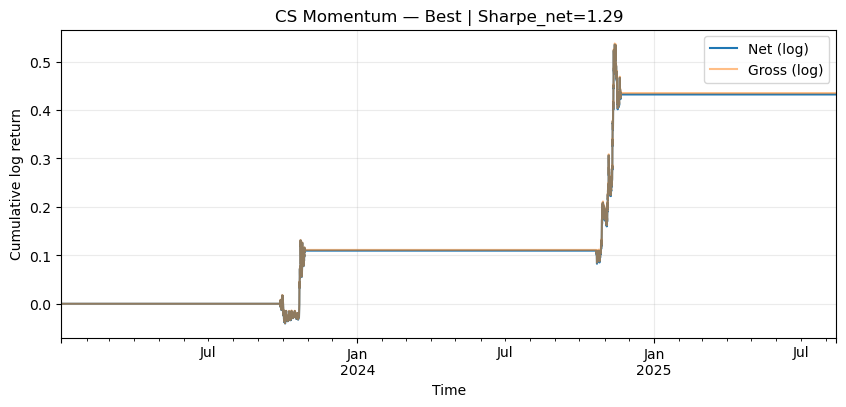

,best_combo
k,336.0000
band,2.5000
beta_win,NaN
every,720.0000
vol_win,168.0000
sharpe_gross,1.2972
sharpe_net,1.2888
ann_ret_gross,0.1660
ann_ret_net,0.1650
ann_vol_gross,0.1280


In [20]:
if best is None:
    print("No momentum config produced a finite Sharpe. Try different k/band/every.")
else:
    w_best, net_best, gross_best = best
    cum_net = net_best.fillna(0).cumsum()
    cum_gross = gross_best.fillna(0).cumsum()

    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    cum_net.plot(ax=ax, label="Net (log)")
    cum_gross.plot(ax=ax, label="Gross (log)", alpha=0.5)
    ax.set_title(f"CS Momentum — Best | Sharpe_net={best_meta['sharpe_net']:.2f}")
    ax.set_xlabel("Time"); ax.set_ylabel("Cumulative log return")
    ax.legend(); ax.grid(True, alpha=0.25)
    plt.show()

    display(pd.Series(best_meta).to_frame("best_combo"))

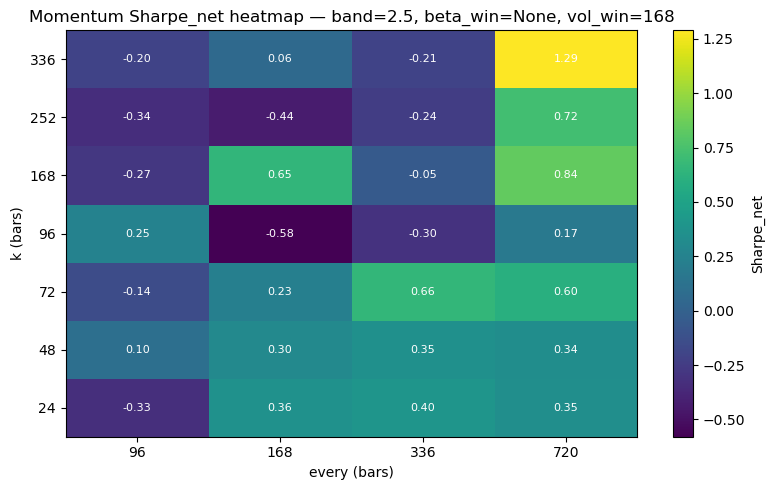

In [21]:
BAND, BETA, VOL = best_meta["band"], best_meta["beta_win"], best_meta["vol_win"]

sl = (res_m["band"]==BAND) & (res_m["beta_win"].fillna(-1)==(BETA if BETA is not None else -1)) \
     & (res_m["vol_win"].fillna(-1)==(VOL if VOL is not None else -1))
heat = res_m.loc[sl, ["k","every","sharpe_net"]].pivot_table(index="k", columns="every", values="sharpe_net", aggfunc="max")

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(heat.values, aspect="auto", origin="lower")
ax.set_xticks(range(len(heat.columns))); ax.set_xticklabels(heat.columns.astype(int))
ax.set_yticks(range(len(heat.index)));   ax.set_yticklabels(heat.index.astype(int))
ax.set_xlabel("every (bars)"); ax.set_ylabel("k (bars)")
ax.set_title(f"Momentum Sharpe_net heatmap — band={BAND}, beta_win={BETA}, vol_win={VOL}")
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        v = heat.values[i,j]; txt = "" if np.isnan(v) else f"{v:.2f}"
        ax.text(j, i, txt, ha="center", va="center", fontsize=8, color="white" if not np.isnan(v) else "black")
fig.colorbar(im, ax=ax, label="Sharpe_net"); plt.tight_layout(); plt.show()

In [22]:
split_date = ret.index[int(len(ret)*0.7)]
R_tr, R_te = ret.loc[:split_date], ret.loc[split_date:]

# rebuild weights on full sample
w_full = cs_momentum_weights(ret, k=best_meta["k"], band=best_meta["band"],
                             beta_win=best_meta["beta_win"], bench=BENCH, vol_win=best_meta["vol_win"])
w_full = downsample_weights(w_full, every=best_meta["every"])
net_full, _, _ = backtest(w_full, ret, cost_rate=COST_RATE)

st_tr, st_te = perf_stats(net_full.loc[R_tr.index]), perf_stats(net_full.loc[R_te.index])
print("Train:", st_tr); print("Test :", st_te)
pd.DataFrame([st_tr, st_te], index=["Train","Test"])

Train: {'ann_ret': 0.10838920942925626, 'ann_vol': 0.08925101591192376, 'sharpe': 1.214431099991274}
Test : {'ann_ret': 0.30078649366840865, 'ann_vol': 0.18979442890920872, 'sharpe': 1.5848014896806841}


,ann_ret,ann_vol,sharpe
Train,0.1084,0.0893,1.2144
Test,0.3008,0.1898,1.5848


## Momentum Results — Summary

**Top configuration (by net Sharpe):**
- `k = 336` (≈ 14 days), `band = 2.5`, `beta_win = None` (no residualization)  
- `every = 720` (≈ 30 days), `vol_win = 168` (≈ 7 days)  
- **Full-sample net Sharpe ≈ 1.29** (gross ≈ 1.30)  
- **Turnover ≈ 1.53/yr**, **cost drag ≈ 0.001/yr** (very low)

**Walk-forward (best config):**
- **Train:** ann. ret ≈ 0.108, ann. vol ≈ 0.089, **Sharpe ≈ 1.21**  
- **Test:**  ann. ret ≈ 0.301, ann. vol ≈ 0.190, **Sharpe ≈ 1.58**

**Other strong runners (top 10):**
- Residualized variants (`beta_win = 168`) reach net Sharpe ≈ 0.92–0.94 with **higher turnover** (≈ 5–12/yr) and slightly higher cost drag (≈ 0.004–0.009/yr).
- Across the top set, **longer lookbacks (k = 168–336)** and **infrequent rebalancing (every = 336–720)** dominate, with **band = 2.5** consistently helpful.

**Takeaway:** CS-momentum is competitive with **very low turnover** when run at **long lookbacks** and **monthly-ish rebalancing**, even **without residualization**. It provides a clean, low-cost baseline against which the reversal strategy’s higher-frequency edge can be compared.
